# Frozen Lake

In [1]:
import gym
import numpy as np
import pygame

np.random.seed(28)

In [2]:
# Create the FrozenLake environment
env = gym.make('FrozenLake-v1', map_name="4x4", render_mode="human",is_slippery=False)
env.reset()

# render the environment
env.render()

## 0. How it works

In [3]:
env.step(2) # right

(1, 0.0, False, False, {'prob': 1.0})

In [4]:
env.step(0) # left

(0, 0.0, False, False, {'prob': 1.0})

In [5]:
env.step(1) # down

(4, 0.0, False, False, {'prob': 1.0})

In [6]:
env.step(3) # up

(0, 0.0, False, False, {'prob': 1.0})

In [7]:
observation, reward, terminated, truncated, info = env.step(2) 

print(observation, reward, terminated, truncated, info)

1 0.0 False False {'prob': 1.0}


In [8]:
env.reset()

(0, {'prob': 1})

In [9]:
env.close()
pygame.quit()

## 1. Learning Predictions

We take random action and estimate the predictions of the previously taken action. With enough repetitions, we should find the best path.

On top of the regular reward, we decide to introduce a negative reward (penalty) for walking into a wall or falling into a lake.

In [10]:
# Create the FrozenLake environment
env = gym.make('FrozenLake-v1', is_slippery=False)
env.reset()

# render the environment
#env.render()

(0, {'prob': 1})

In [11]:
n_obs = env.observation_space.n
n_act = env.action_space.n
preds = np.zeros((n_obs, n_act))

print(preds) # prediction matrix

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [12]:
N = 10

# we repeat the game until the reward is found N times
for _ in range(N):
    prev_state = env.observation_space.start
    reward = 0
    
    while reward == 0:
        # choose and take random action
        action = env.action_space.sample() 
        observation, reward, terminated, truncated, info = env.step(action) 
        
         # found reward
        if reward == 1:
            update = np.mean([preds[prev_state][action], 1])
            
        # fell into lake
        elif terminated: 
            update = np.mean([preds[prev_state][action], -1])
            
         # walked into wall
        elif prev_state == observation:
            update = np.mean([preds[prev_state][action], -1])
            
        # just some step | in this case we use the mean prediction of all possible next actions
        else: 
            update = np.mean(preds[observation])
            
        # update prediction of previous state-action pair
        preds[prev_state][action] = update
        
        # set new previous state
        prev_state = observation
        
        # reset game
        if terminated or truncated:
            env.reset()

In [13]:
preds

array([[-1.        , -0.99290703, -0.99570273, -1.        ],
       [-0.99715179, -1.        , -0.98565914, -1.        ],
       [-0.99570273, -0.95051907, -0.99641477, -1.        ],
       [-0.98565907, -1.        , -1.        , -1.        ],
       [-1.        , -0.97447635, -1.        , -0.99715179],
       [-0.99715179, -0.99290703, -0.99570273, -0.99715178],
       [-1.        , -0.81668921, -1.        , -0.98565882],
       [-0.99714066, -0.99290417, -0.99570244, -0.99713692],
       [-1.        , -1.        , -0.90500979, -0.99289574],
       [-0.97445162, -0.82899681, -0.81668879, -0.99999952],
       [-0.90492925, -0.4113699 , -0.99996948, -0.95051874],
       [-0.99715244, -0.98907595, -0.99568865, -0.9971441 ],
       [-0.99715179, -0.99290703, -0.99570273, -0.99714938],
       [-0.99975586, -0.99998474, -0.41149216, -0.90494451],
       [-0.82756976, -0.99996948,  0.99902344, -0.81650679],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [14]:
# taking the actions with the highest prediction

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
env.reset()
reward = 0 
observation = env.observation_space.start

while reward == 0:
    action = np.argmax(preds[observation])
    observation, reward, terminated, truncated, info = env.step(action)
    
env.close()
pygame.quit()

## 2. Estimating transitional probabilities and rewards

We want to estimate the trans. probs now. In the previous part they were all 1 since we always went in the direction we wanted. If we set "is_slippery = True", we only go in that direction with p = 1/3. With equal probabilty, we choose one of the 2 neighboring directions. For example, if we choose DOWN, we might also go LEFT or RIGHT but not UP; and if we choose LEFT, we could also go UP or DOWN but not RIGHT. 


As previously, we take random actions. Now we don't estimate the predictions but the the probabilities and rewards separately.

In [15]:
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()

(0, {'prob': 1})

In [16]:
n_obs = env.observation_space.n
n_act = env.action_space.n

# for every state, we want to estimate the reward
rewards = np.zeros(n_obs)

# we initialize the transitional probabilities as a dictionary
# for every pair (s, a), we want to find the probabilities for possible next states s'
# so every time a new state s' appears, we will add it to the dict
# otherwise, we would need a pretty big matrix
trans_probs = {}
# to estimate them, we need to know how many times we chose a specific action for a specific state
state_action_counter = np.zeros((n_obs, n_act))

print('rewards = \n', rewards, end='\n\n')
print('transitional probabilities = \n', trans_probs) # prediction matrix

rewards = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

transitional probabilities = 
 {}


In [17]:
N = 100

# we repeat the game until the reward is found N times
for _ in range(N):
    prev_state = env.observation_space.start
    reward = 0
    
    while reward == 0:
        # choose and take random action
        action = env.action_space.sample() 
        observation, reward, terminated, truncated, info = env.step(action) 
        
        ###################################
        # update transitional probabilities
        if (prev_state, action) not in trans_probs:
            trans_probs[(prev_state, action)] = {}
        if observation not in trans_probs[(prev_state, action)]:
            trans_probs[(prev_state, action)][observation] = 0
        
        state_action_counter[prev_state][action] += 1
        
        trans_probs[(prev_state, action)][observation] += (1 / state_action_counter[prev_state][action])
        
        denominator = sum(trans_probs[(prev_state, action)].values())
        for new_state in trans_probs[(prev_state, action)].keys():
            trans_probs[(prev_state, action)][new_state] /= denominator
        
        #############################
        # compute updates for rewards
        # since walking into a wall is no state change, we can't take it into account here
        # also, in the probabilistic case, it can actually be a good policy
        
        # reward is found
        if reward == 1:
            rew_update = np.mean([rewards[observation], 1])
            rewards[observation] = rew_update
            
        # fell into lake
        elif terminated: 
            rew_update = np.mean([rewards[observation], -1])
            rewards[observation] = rew_update
        
        # set new previous state
        prev_state = observation
        
        # reset game
        if terminated or truncated:
            env.reset()
            prev_state = env.observation_space.start
            
env.close()
pygame.quit()

In [18]:
rewards

array([ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0., -1., -1.,
        0.,  0.,  1.])

In [19]:
trans_probs

{(0, 2): {0: 0.3295306388526725,
  1: 0.3274119947848754,
  4: 0.34305736636245215},
 (0, 1): {4: 0.33028122956180467,
  0: 0.33060824068018224,
  1: 0.339110529758013},
 (4, 0): {4: 0.3285044737963356,
  8: 0.3510864933958238,
  0: 0.32040903280784055},
 (4, 3): {5: 0.33685545224006797,
  4: 0.3381234150464917,
  0: 0.32502113271344035},
 (0, 0): {4: 0.3228092783505148, 0: 0.6771907216494851},
 (4, 1): {4: 0.3176059414591528,
  8: 0.3499344692005238,
  5: 0.33245958934032344},
 (4, 2): {5: 0.3425414364640889, 8: 0.3280917977050572, 0: 0.3293667658308539},
 (8, 3): {9: 0.32746478873239454,
  4: 0.33920187793427203,
  8: 0.3333333333333334},
 (9, 2): {10: 0.38461538461538425,
  5: 0.27272727272727293,
  13: 0.34265734265734277},
 (10, 2): {14: 0.3241758241758242,
  6: 0.3516483516483519,
  11: 0.324175824175824},
 (14, 3): {15: 0.2844036697247706,
  13: 0.3944954128440367,
  10: 0.3211009174311926},
 (0, 3): {1: 0.33190612115445556, 0: 0.6680938788455445},
 (1, 2): {1: 0.344682639764607

Now, we can use these to compute the expected returns of all state action pairs... But it's very annoying to figure out how exactly.

## 3. Reinforement Learning

We use the Bellman equations with RL. To apply them, we need our previously estimated returns and transitional probabilities. 

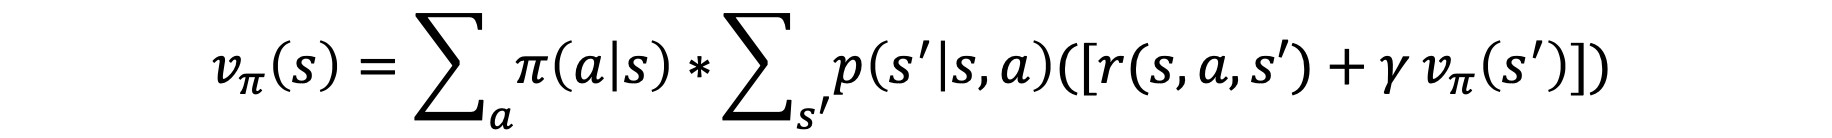

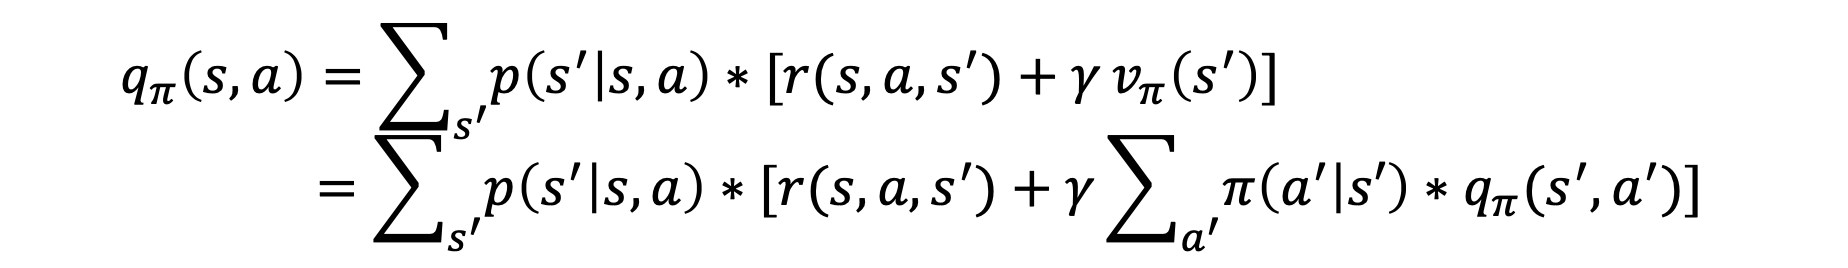

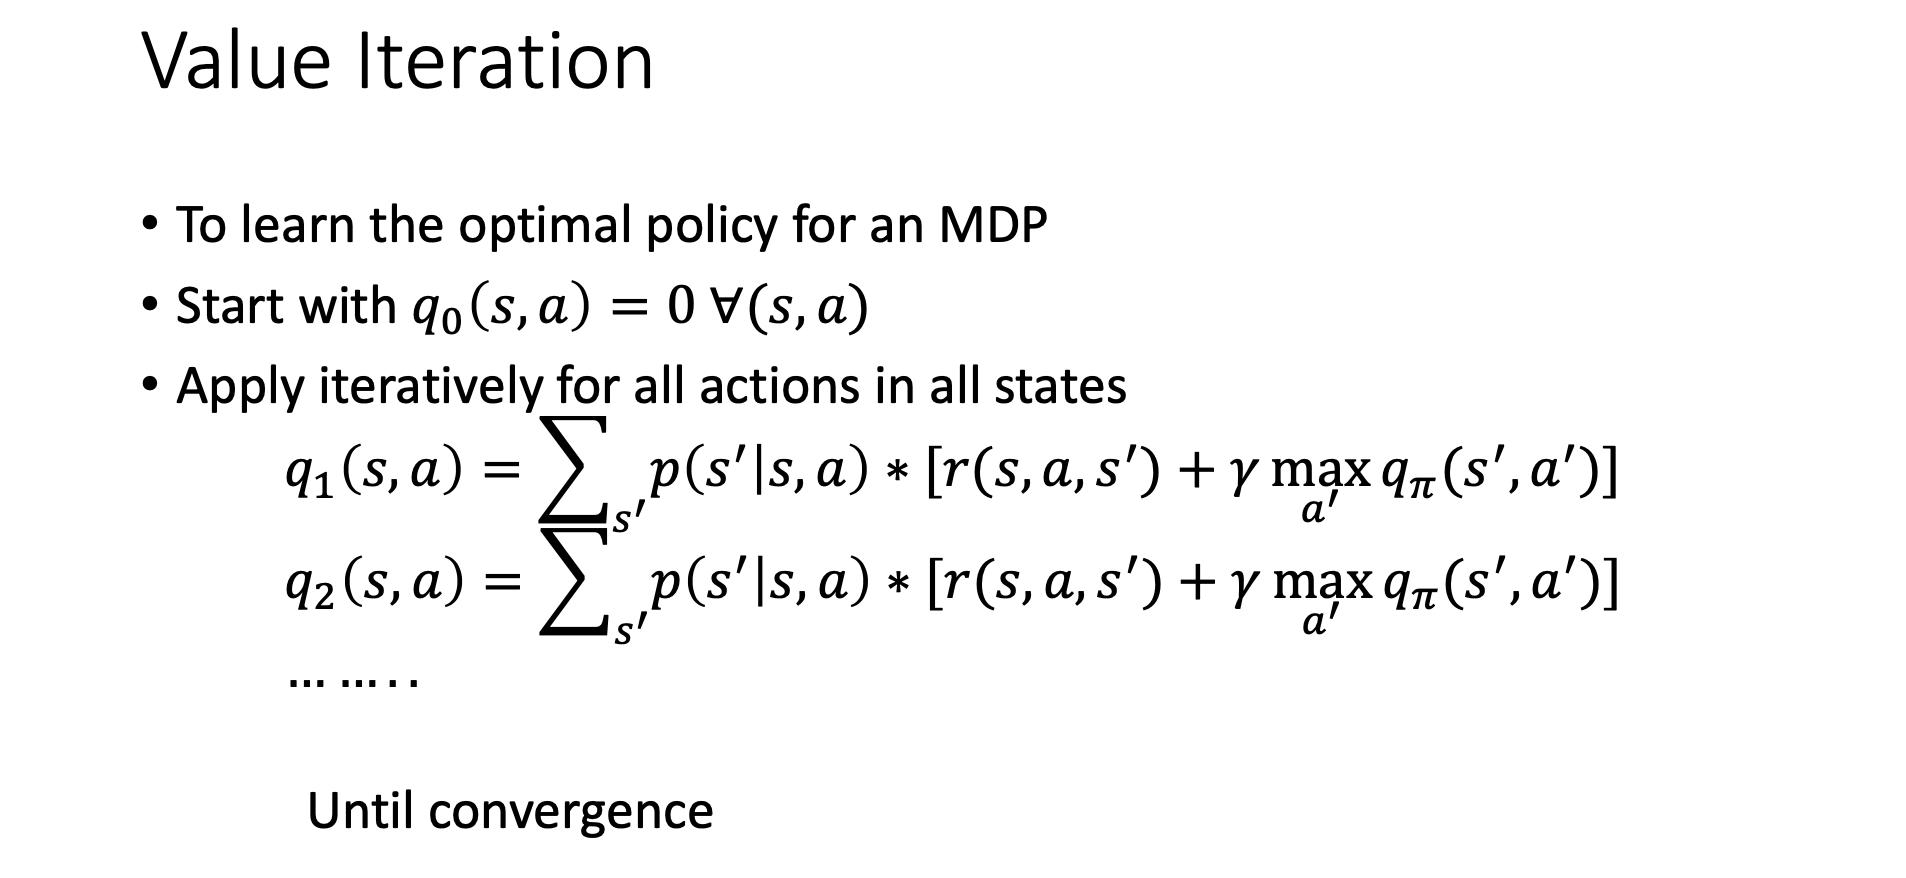

In [20]:
# one q value for each state-action pair
q_values = np.zeros((n_obs, n_act))

In [21]:
def compute_q(state, action, gamma):
    q = 0
    for next_state in trans_probs[(state, action)]:
        max_next_q = np.max(q_values[next_state])
        q += trans_probs[(state, action)][next_state] * (rewards[next_state] + gamma * max_next_q)
        
    return q

N = 1000
# discount factor (some parameter)
gamma = 0.99

for _ in range(N):
    for s in range(n_obs):
        for a in range(n_act):
            try: 
                q_values[s, a] = compute_q(s, a, gamma)
            except:
                pass
            

print(q_values)

In [34]:
rl_order = np.argmax(q_values, axis=1)
print(rl_order)

[1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


In [24]:
rewards

array([ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0., -1., -1.,
        0.,  0.,  1.])

In [25]:
# taking the actions with the highest q values

env = gym.make('FrozenLake-v1', is_slippery=True, render_mode="human")
env.reset()
reward = 0 
observation = env.observation_space.start

while reward == 0:
    action = np.argmax(q_values[observation])
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        env.reset()
    
env.close()
pygame.quit()

## 4. Q-learning

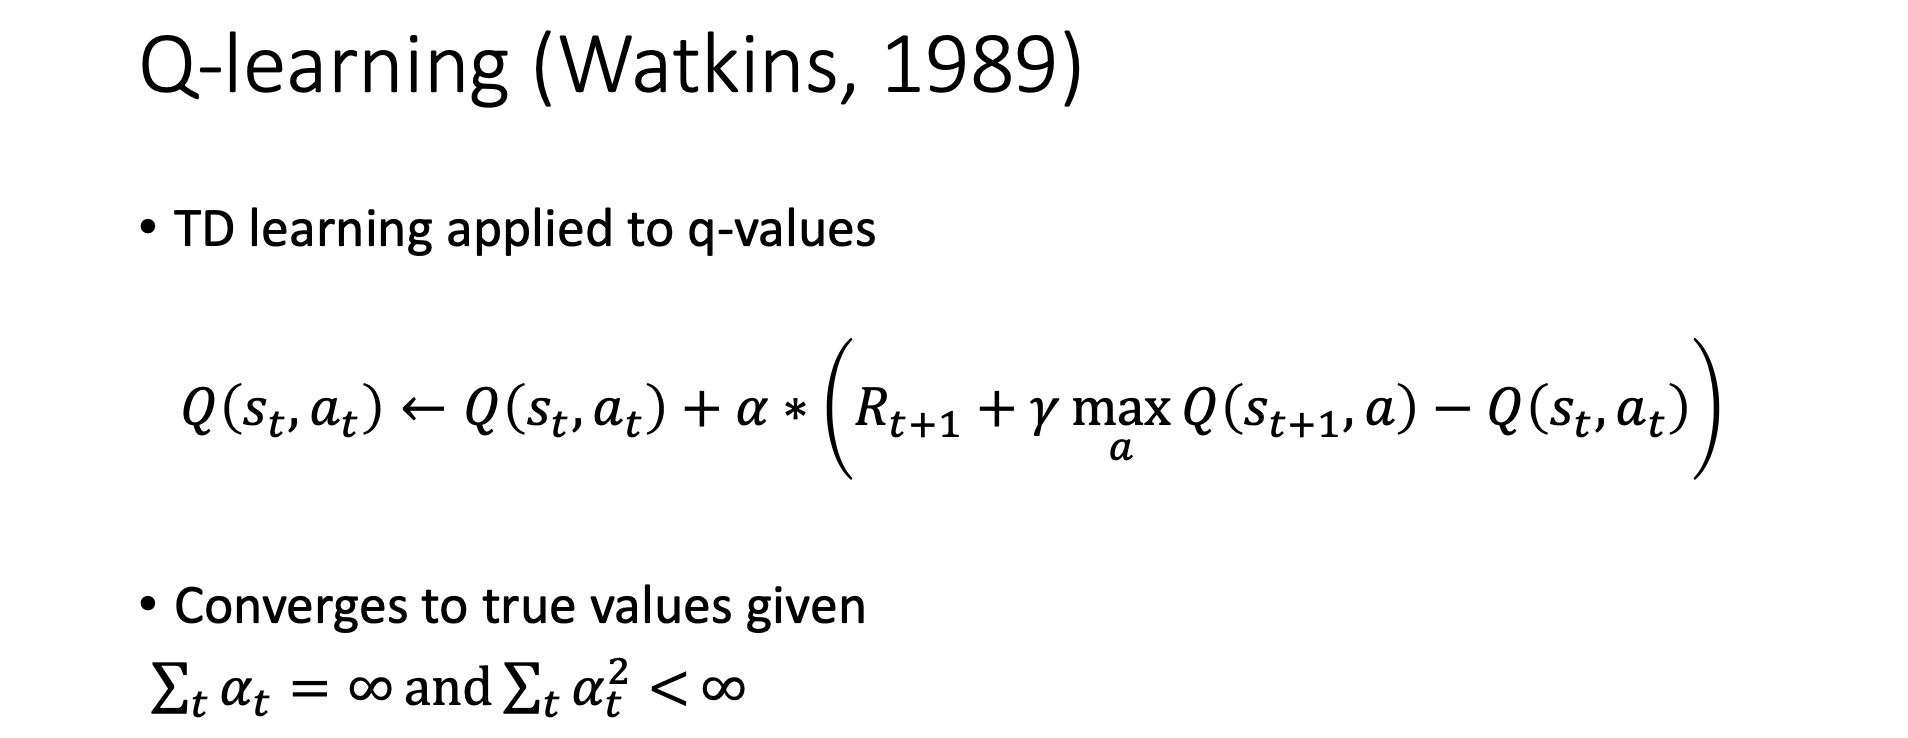

In this case, we are 

In [26]:
# Create the FrozenLake environment
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()

# render the environment
#env.render()

(0, {'prob': 1})

In [27]:
def compute_q_update(s, a, s_prime, q_values, reward, alpha, gamma):
    
    return update

In [28]:
n_obs = env.observation_space.n
n_act = env.action_space.n

# for every state, we want to estimate the reward
rewards = np.zeros(n_obs)

state_action_counter = np.zeros((n_obs, n_act))

q_values = np.zeros((n_obs, n_act))

print('rewards = \n', rewards, end='\n\n')
print('q_values = \n', q_values)

rewards = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

q_values = 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [29]:
N = 1000
gamma = 0.99
def alpha(N):
    return 1/N

# we repeat the game until the reward is found N times
for _ in range(N):
    prev_state = env.observation_space.start
    reward = 0
    
    while reward == 0:
        # choose and take random action
        action = env.action_space.sample() 
        observation, reward, terminated, truncated, info = env.step(action) 
        
        # set reward to -1 if we fell into lake
        if (reward ==0) and terminated: 
            reward = -1
        
        # advance counter
        state_action_counter[prev_state][action] += 1
        
        ###########################
        # compute updates for q values
        n = state_action_counter[prev_state, action]
        update = alpha(n) * (reward + gamma * np.max(q_values[observation]) - q_values[prev_state, action])
        q_values[prev_state, action] += update
        
        # set new previous state
        prev_state = observation
        
        # reset game
        if terminated or truncated:
            env.reset()
            prev_state = env.observation_space.start
            
env.close()
pygame.quit()

In [30]:
q_values

array([[ 2.44026816e-04,  2.49865794e-04,  2.47236743e-04,
         2.96007498e-05],
       [-3.12866750e-01, -2.97451947e-01, -3.16128406e-01,
         1.63314806e-05],
       [-8.38849486e-02, -6.89814895e-02, -9.73532496e-02,
         4.83013993e-07],
       [-3.47826057e-01, -3.62499990e-01, -2.49999999e-01,
         1.47735780e-08],
       [ 3.53711964e-03, -3.22354408e-01, -3.67309026e-01,
        -3.41452512e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.39775977e-01, -6.22563556e-01, -2.59721798e-01,
        -6.19047607e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.76870746e-01, -3.44481007e-01, -2.37695359e-01,
         2.68486152e-02],
       [-2.08137399e-01,  1.73367544e-01, -2.23626263e-01,
        -1.83947840e-01],
       [ 1.74524124e-01,  1.46615410e-03, -1.47821747e-01,
        -2.97442580e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
      

In [38]:
ql_order = np.argmax(q_values, axis=1)

In [39]:
print(ql_order)
print(rl_order)

[1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]
[1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


RL and Q-Learning lead to the same sequence of best moves.

In [40]:
# taking the actions with the highest q values

env = gym.make('FrozenLake-v1', is_slippery=True, render_mode="human")
env.reset()
reward = 0 
observation = env.observation_space.start

while reward == 0:
    action = np.argmax(q_values[observation])
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        env.reset()
    
env.close()
pygame.quit()